In [79]:
import numpy as np
import pandas as pd
import segyio
import lasio
import yaml

from pathlib import Path
from pprint import pprint

from wtie import grid, viz, autotie
from wtie.processing.logs import interpolate_nans, despike
from wtie.utils.datasets import tutorial

import matplotlib.pyplot as plt

In [80]:
# data pathfolder = Path('.'))
seis_path_3d_path = Path(
    "c:\\Users\\Caio\\Downloads\\Rawdata\\Rawdata\\Seismic_data.sgy"
)
seis_path_2d_path = Path(
    "../data/tutorial/Poseidon/boreas1/Boreas1_seismic_alongwell_0_0.sgy"
)

las_log_3d_path = Path(
    "c:\\Users\\Caio\\Downloads\\Rawdata\\Rawdata\\Well_data\\F02-01_logs.las"
)
las_log_2d_path = Path("../data/tutorial/Poseidon/boreas1/Boreas1Decim.las")

In [81]:
with segyio.open(seis_path_2d_path, "r") as f:
    print(f.samples.size)  # number of time samples
    print(f.ilines)
    print(f.xlines)
    print(f.offsets)  # these are actually angles, from 0 to 45 degrees
    print(f.format)
    print(f.header)  # this is the header of the file

with segyio.open(seis_path_3d_path, "r", ignore_geometry=True) as f:
    print(f.samples.size)  # number of time samples
    print(f.ilines)
    print(f.xlines)
    print(f.offsets)  # these are actually angles, from 0 to 45 degrees
    print(f.format)
    print(f.header)  # this is the header of the file
    ilines = [f.header[i][segyio.TraceField.INLINE_3D] for i in range(f.tracecount)]
    xlines = [f.header[i][segyio.TraceField.CROSSLINE_3D] for i in range(f.tracecount)]
    print(set(ilines))
    print(set(xlines))

838
[0]
[0]
[0]
4-byte IBM float
462
None
None
None
2-byte signed integer
{100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 

In [82]:
def detect_segy_format(segy_path):
    with segyio.open(segy_path, "r", ignore_geometry=True) as f:
        ilines = [f.header[i][segyio.TraceField.INLINE_3D] for i in range(f.tracecount)]
        xlines = [
            f.header[i][segyio.TraceField.CROSSLINE_3D] for i in range(f.tracecount)
        ]
        n_ilines = len(set(ilines))
        n_xlines = len(set(xlines))
        if n_ilines == 1 or n_xlines == 1:
            return "2D"
        else:
            return "3D"

In [83]:
las_log_3d = lasio.read(las_log_3d_path)
las_log_3d = las_log_3d.df()

las_log_2d = lasio.read(las_log_2d_path)
las_log_2d = las_log_2d.df()

In [84]:
def import_logs_generic(file_path: str) -> grid.LogSet:
    """
    Importa qualquer arquivo LAS e retorna um grid.LogSet com todos os logs disponíveis,
    mapeando nomes alternativos para 'Vp' e 'Rho' se necessário e interpolando para base regular.
    """
    file_path = Path(file_path)
    las_logs = lasio.read(file_path)
    las_df = las_logs.df()
    logs = {}
    # Define base regular (usando o menor passo encontrado)
    md = las_df.index.values
    step = np.min(np.diff(md))
    md_regular = np.arange(md[0], md[-1] + step, step)
    # Mapeamento de nomes alternativos
    name_map = {
        "Vp": [
            col
            for col in las_df.columns
            if col.startswith("DT") or col.upper() in ["VP", "DTCO", "SONIC"]
        ],
        "Rho": [
            col
            for col in las_df.columns
            if col.upper() in ["RHO", "RHOB", "RHOZ", "DENS"]
        ],
    }
    # Primeiro, tenta mapear os obrigatórios
    for key, aliases in name_map.items():
        for alias in aliases:
            if alias in las_df.columns:
                values = las_df[alias].values
                # Interpola para base regular
                interp_values = np.interp(md_regular, md, interpolate_nans(values))
                if key == "Vp":
                    if np.nanmean(values) > 100:  # provavelmente DT
                        interp_values = 1 / interp_values * 1e6 / 3.2808  # ft/us -> m/s
                logs[key] = grid.Log(interp_values, md_regular, "md", name=key)
                break
    # Adiciona os demais logs
    for col in las_df.columns:
        if col not in logs:
            try:
                values = las_df[col].values
                interp_values = np.interp(md_regular, md, interpolate_nans(values))
                logs[col] = grid.Log(interp_values, md_regular, "md", name=col)
            except Exception as e:
                print(f"Não foi possível importar o log {col}: {e}")
    return grid.LogSet(logs=logs)

In [ ]:
import wtie.utils.datasets.poseidon as dataset

"""TODO: arrumar essa função para receber mais do que as funções já implementadas pelo código"""
def import_well_path_generic(file_path: str, kb: float = 0):
    if 'Boreas1_dev.txt' == file_path or 'Pharos1_dev_raw.txt' == file_path or 'Torosa1_dev.txt' == file_path:
        if file_path == 'Boreas1_dev.txt':
            return dataset.import_well_path(file_path, well='boreas1')
        if file_path == 'Pharos1_dev_raw.txt':
            return dataset.import_well_path(file_path, well='pharos1')
        if file_path == 'Torosa1_dev.txt':
            return dataset.import_well_path(file_path, well='torosa1')
    else:
        # Acho que preciso fazer ser uma seleção manual por parte do usuário infelizmente
        # Cada CSV tem um formato diferente, então não dá para fazer uma função genérica
        file_path = Path(file_path)
        wp = pd.read_csv(file_path, delimiter=r"\s+")
        return grid.WellPath(md=wp.loc[:, 'Depth'].values, tvdss=tvd, kb=kb)
    

In [ ]:
#TODO: Consertar o import da time_depth_table (funciona apenas para uma função eu acredito)
def import_time_depth_table_generic(file_path: str) -> grid.TimeDepthTable:
    """
    Importa uma tabela tempo/profundidade genérica.
    """
    file_path = Path(file_path)

    # Lê o arquivo ignorando comentários
    df = pd.read_csv(
        file_path, delimiter=r"\s+", header=None, comment="#", skip_blank_lines=True
    )

    # Verifica o formato pelo número de colunas
    if len(df.columns) >= 6:
        # Reorganiza os dados das 6 colunas
        data = []
        for _, row in df.iterrows():
            data.extend([(row[2], row[1]), (row[5], row[4])])
        df_clean = pd.DataFrame(data, columns=["TWT", "TVD_SS"])
    else:
        df_clean = df.iloc[:, :2]
        df_clean.columns = ["TWT", "TVD_SS"]

    # Limpa e ordena os dados
    df_clean = df_clean.apply(pd.to_numeric, errors="coerce").dropna()
    df_clean = df_clean.sort_values("TWT").drop_duplicates("TWT")

    # Extrai os arrays
    twt = df_clean["TWT"].values
    tvdss = df_clean["TVD_SS"].values

    # OWT para TWT (se necessário)
    if np.mean(twt) < 1:  # provavelmente OWT
        twt = 2 * twt  # converte para TWT

    return grid.TimeDepthTable(twt=twt, tvdss=tvdss)

In [87]:
def import_seismic_trace(file_path: str, trace_idx: int = 0) -> grid.Seismic:
    """
    Importa um arquivo SEGY e retorna apenas um traço específico como grid.Seismic.
    TODO: Melhorar a importação para lidar com diferentes formatos de SEGY (1D/2D/3D).
    """
    file_path = Path(file_path)
    with segyio.open(file_path, "r", ignore_geometry=True) as f:
        twt = f.samples / 1000  # ms para s
        trace = f.trace[trace_idx]  # pega o traço desejado
    return grid.Seismic(trace, twt, "twt", name=f"{file_path.stem}_trace{trace_idx}")

In [88]:
from wtie.utils.datasets.utils import InputSet

log_path = "../data/tutorial/Poseidon/boreas1/Boreas1Decim.las"
seismic_path = "../data/tutorial/Poseidon/boreas1/Boreas1_seismic_alongwell_0_0.sgy"
wellpath_path = "../data/tutorial//Poseidon/boreas1/Boreas1_dev.txt"
td_table_path = "../data/tutorial/Poseidon/boreas1/Boreas1_vel.txt"

logset_md = import_logs_generic(log_path)
seismic = import_seismic_trace(seismic_path)
wellpath = import_well_path_generic(wellpath_path)
td_table = import_time_depth_table_generic(td_table_path)

inputs = InputSet(
    logset_md=logset_md, seismic=seismic, wellpath=wellpath, table=td_table
)

In [89]:
model_state_dict = Path("../data/tutorial/trained_net_state_dict.pt")
assert model_state_dict.is_file()

with open(Path("../data/tutorial/network_parameters.yaml"), "r") as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)

wavelet_extractor = tutorial.load_wavelet_extractor(
    training_parameters, model_state_dict
)

Loading network parameters from ..\data\tutorial\trained_net_state_dict.pt


In [90]:
modeler = tutorial.get_modeling_tool()

In [91]:
print(autotie.tie_v1.__doc__)
print(autotie.get_default_search_space_v1.__doc__)


    Utility to perform automatic (prestack) seismic to well tie. This version 1
    serves as a base recipe. Feel free to implement your own recipe using the
    various tools of the package.

    Parameters
    ----------
    inputs : _tie.InputSet
        Necessary inputs for the well tie.
    wavelet_extractor : wtie.learning.model.BaseEvaluator
        Object to extract a wavelet using the provided neural network.
    modeler : wtie.modeling.modeling.ModelingCallable
        Synthetic modeling tool.
    wavelet_scaling_params : dict
        Parameters for the search of the optimal absolute wavelet sacle.
        3 parameters: 'wavelet_min_scale' and 'wavelet_max_scale' are the search
        bounds. 'num_iters' (optional) is the total number of iterations for the
        search.
    search_space : dict, optional
        Bounds of the search space. See `get_default_search_space_v1`.
    search_params : dict, optional
        Dict with 3 parameters for the Bayesian search. 'num_iter

In [92]:
median_length_choice = dict(
    name="logs_median_size",
    type="choice",
    values=[i for i in range(11, 63, 2)],
    value_type="int",
)

median_th_choice = dict(
    name="logs_median_threshold", type="range", bounds=[0.1, 5.5], value_type="float"
)

std_choice = dict(name="logs_std", type="range", bounds=[0.5, 5.5], value_type="float")

table_t_shift_choice = dict(
    name="table_t_shift", type="range", bounds=[-0.012, 0.012], value_type="float"
)

search_space = [
    median_length_choice,
    median_th_choice,
    std_choice,
    table_t_shift_choice,
]

In [93]:
search_params = dict(num_iters=80, similarity_std=0.02)

In [94]:
wavelet_scaling_params = dict(
    wavelet_min_scale=50000, wavelet_max_scale=500000, num_iters=60
)

In [95]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


outputs = autotie.tie_v1(
    inputs,
    wavelet_extractor,
    modeler,
    wavelet_scaling_params,
    search_params=search_params,
    search_space=search_space,
    stretch_and_squeeze_params=None,
)

stage 0
Tensor Details:
- Size: torch.Size([256, 256, 3])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([256])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([256])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([128, 256])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([128])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([128, 256])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([128])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([512, 128])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor Details:
- Size: torch.Size([512])
- Device: cuda:0
- Type: <class 'torch.nn.parameter.Parameter'>

Tensor

  0%|          | 0/80 [00:00<?, ?it/s][WARNING 08-04 00:08:09] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 08-04 00:08:09] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(auto well tie) (type: <class '

upper
[ 58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58.48465545  58.48465545  58.48465545  58.48465545  58.48465545
  58

  1%|▏         | 1/80 [00:12<16:35, 12.60s/it][WARNING 08-04 00:08:21] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:21] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:21] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 1 (type: <class 'int'>).
[WARNING 08-04 00:08:21] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:21] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[ 58.48517604  58.48517604  58.48517604  58.48517604  58.48517603
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517603  58.48517604  58.48517604  58.48517603  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517603  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58.48517604  58.48517604  58.48517604  58.48517604  58.48517604
  58

  2%|▎         | 2/80 [00:13<07:33,  5.81s/it][WARNING 08-04 00:08:22] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:22] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:22] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 2 (type: <class 'int'>).
[WARNING 08-04 00:08:22] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:22] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[ 58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58.48520437  58.48520437  58.48520437  58.48520437  58.48520437
  58

[WARNING 08-04 00:08:23] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:23] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 3 (type: <class 'int'>).
[WARNING 08-04 00:08:23] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:23] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:23] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got S

upper
[ 58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58.48565182  58.48565182  58.48565182  58.48565182  58.48565182
  58

[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 4 (type: <class 'int'>).
[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneTy

upper
[ 58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58.48512153  58.48512153  58.48512153  58.48512153  58.48512153
  58

[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 5 (type: <class 'int'>).
[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:24] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneTy

upper
[ 58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58.48455818  58.48455818  58.48455818  58.48455818  58.48455818
  58

  8%|▊         | 6/80 [00:16<01:47,  1.45s/it][WARNING 08-04 00:08:25] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:25] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:25] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 6 (type: <class 'int'>).
[WARNING 08-04 00:08:25] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:25] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[ 58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58.48530136  58.48530136  58.48530136  58.48530136  58.48530136
  58

  9%|▉         | 7/80 [00:17<01:29,  1.22s/it][WARNING 08-04 00:08:26] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:26] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:26] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 7 (type: <class 'int'>).
[WARNING 08-04 00:08:26] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:26] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[ 58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58.48552831  58.48552831  58.48552831  58.48552831  58.48552831
  58

 10%|█         | 8/80 [00:18<01:20,  1.12s/it][WARNING 08-04 00:08:27] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:27] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:27] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 8 (type: <class 'int'>).
[WARNING 08-04 00:08:27] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:27] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[ 58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58.48484345  58.48484345  58.48484345  58.48484345  58.48484345
  58

 11%|█▏        | 9/80 [00:19<01:17,  1.09s/it][WARNING 08-04 00:08:28] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:28] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:28] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 9 (type: <class 'int'>).
[WARNING 08-04 00:08:28] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:28] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndar

upper
[ 58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58.48465041  58.48465041  58.48465041  58.48465041  58.48465041
  58

 12%|█▎        | 10/80 [00:19<01:08,  1.02it/s][WARNING 08-04 00:08:29] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:29] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:29] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 10 (type: <class 'int'>).
[WARNING 08-04 00:08:29] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:29] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58.48425899  58.48425899  58.48425899  58.48425899  58.48425899
  58

 14%|█▍        | 11/80 [00:20<01:05,  1.05it/s][WARNING 08-04 00:08:30] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:30] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:30] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 11 (type: <class 'int'>).
[WARNING 08-04 00:08:30] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:30] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58.48543634  58.48543634  58.48543634  58.48543634  58.48543634
  58

 15%|█▌        | 12/80 [00:21<01:03,  1.07it/s][WARNING 08-04 00:08:31] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:31] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:31] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 12 (type: <class 'int'>).
[WARNING 08-04 00:08:31] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:31] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58.48518199  58.48518199  58.48518199  58.48518199  58.48518199
  58

 16%|█▋        | 13/80 [00:22<01:06,  1.01it/s][WARNING 08-04 00:08:32] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:32] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:32] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 13 (type: <class 'int'>).
[WARNING 08-04 00:08:32] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:32] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58.48494482  58.48494482  58.48494482  58.48494482  58.48494482
  58

[WARNING 08-04 00:08:33] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:33] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:33] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 14 (type: <class 'int'>).
[WARNING 08-04 00:08:33] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:33] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58.48476298  58.48476298  58.48476298  58.48476298  58.48476298
  58

 19%|█▉        | 15/80 [00:25<01:08,  1.06s/it][WARNING 08-04 00:08:34] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:34] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:34] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 15 (type: <class 'int'>).
[WARNING 08-04 00:08:34] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:34] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58.48507021  58.48507021  58.48507021  58.48507021  58.48507021
  58

[WARNING 08-04 00:08:35] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:35] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:35] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 16 (type: <class 'int'>).
[WARNING 08-04 00:08:35] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:35] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58.48567906  58.48567906  58.48567906  58.48567906  58.48567906
  58

[WARNING 08-04 00:08:36] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:36] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:36] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 17 (type: <class 'int'>).
[WARNING 08-04 00:08:36] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:36] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58.48602861  58.48602861  58.48602861  58.48602861  58.48602861
  58

[WARNING 08-04 00:08:37] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:37] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:37] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 18 (type: <class 'int'>).
[WARNING 08-04 00:08:37] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:37] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4843688   58.4843688   58.4843688   58.4843688
  58.4843688   58.4

 24%|██▍       | 19/80 [00:28<01:02,  1.02s/it][WARNING 08-04 00:08:38] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:38] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:38] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 19 (type: <class 'int'>).
[WARNING 08-04 00:08:38] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:38] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58.48483414  58.48483414  58.48483414  58.48483414  58.48483414
  58

[WARNING 08-04 00:08:39] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:39] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:39] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 20 (type: <class 'int'>).
[WARNING 08-04 00:08:39] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:39] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490163
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490163  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58.48490162  58.48490162  58.48490162  58.48490162  58.48490162
  58

[WARNING 08-04 00:08:40] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:40] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:40] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 21 (type: <class 'int'>).
[WARNING 08-04 00:08:40] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:40] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58.48505497  58.48505497  58.48505497  58.48505497  58.48505497
  58

 28%|██▊       | 22/80 [00:31<00:59,  1.02s/it][WARNING 08-04 00:08:41] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:41] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:41] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 22 (type: <class 'int'>).
[WARNING 08-04 00:08:41] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:41] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58.48581772  58.48581772  58.48581772  58.48581772  58.48581772
  58

[WARNING 08-04 00:08:42] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:42] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:42] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 23 (type: <class 'int'>).
[WARNING 08-04 00:08:42] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:42] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4848566   58.4848566   58.4848566   58.4848566
  58.4848566   58.4

[WARNING 08-04 00:08:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 24 (type: <class 'int'>).
[WARNING 08-04 00:08:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:43] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58.48541155  58.48541155  58.48541155  58.48541155  58.48541155
  58

[WARNING 08-04 00:08:44] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:44] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:44] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 25 (type: <class 'int'>).
[WARNING 08-04 00:08:44] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:44] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58.48476788  58.48476788  58.48476788  58.48476788  58.48476788
  58

[WARNING 08-04 00:08:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 26 (type: <class 'int'>).
[WARNING 08-04 00:08:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:46] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58.48441757  58.48441757  58.48441757  58.48441757  58.48441757
  58

[WARNING 08-04 00:08:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 27 (type: <class 'int'>).
[WARNING 08-04 00:08:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:47] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58.48512066  58.48512066  58.48512066  58.48512066  58.48512066
  58

[WARNING 08-04 00:08:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 28 (type: <class 'int'>).
[WARNING 08-04 00:08:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:48] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522     58.48522
  58.48522     58.48522     58.48522     58.48522

[WARNING 08-04 00:08:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 29 (type: <class 'int'>).
[WARNING 08-04 00:08:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:49] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48485546  58.48485545  58.48485545  58.48485545  58.48485546
  58.48485546  58.48485546  58.48485546  58.48485546  58.48485545
  58.48485546  58.48485546  58.48485545  58.48485545  58.48485546
  58.48485546  58.48485545  58.48485546  58.48485546  58.48485546
  58.48485546  58.48485545  58.48485546  58.48485546  58.48485545
  58.48485545  58.48485545  58.48485545  58.48485546  58.48485546
  58.48485545  58.48485545  58.48485546  58.48485546  58.48485546
  58.48485545  58.48485546  58.48485546  58.48485545  58.48485545
  58.48485546  58.48485546  58.48485545  58.48485546  58.48485546
  58.48485546  58.48485546  58.48485545  58.48485545  58.48485546
  58.48485546  58.48485546  58.48485545  58.48485546  58.48485546
  58.48485545  58.48485546  58.48485545  58.48485546  58.48485546
  58.48485545  58.48485545  58.48485546  58.48485545  58.48485545
  58.48485546  58.48485545  58.48485545  58.48485546  58.48485546
  58.48485546  58.48485546  58.48485545  58.48485545  58.48485546
  58

 38%|███▊      | 30/80 [00:40<00:52,  1.05s/it][WARNING 08-04 00:08:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 30 (type: <class 'int'>).
[WARNING 08-04 00:08:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:50] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58.48479691  58.48479691  58.48479691  58.48479691  58.48479691
  58

[WARNING 08-04 00:08:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 31 (type: <class 'int'>).
[WARNING 08-04 00:08:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:51] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58.48522224  58.48522224  58.48522224  58.48522224  58.48522224
  58

 40%|████      | 32/80 [00:42<00:55,  1.15s/it][WARNING 08-04 00:08:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 32 (type: <class 'int'>).
[WARNING 08-04 00:08:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:52] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58.48524361  58.48524361  58.48524361  58.48524361  58.48524361
  58

 41%|████▏     | 33/80 [00:44<00:57,  1.22s/it][WARNING 08-04 00:08:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 33 (type: <class 'int'>).
[WARNING 08-04 00:08:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:54] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58.48460565  58.48460565  58.48460565  58.48460565  58.48460565
  58

[WARNING 08-04 00:08:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 34 (type: <class 'int'>).
[WARNING 08-04 00:08:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:55] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58.48437382  58.48437382  58.48437382  58.48437382  58.48437382
  58

[WARNING 08-04 00:08:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 35 (type: <class 'int'>).
[WARNING 08-04 00:08:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:57] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58.48502714  58.48502714  58.48502714  58.48502714  58.48502714
  58

[WARNING 08-04 00:08:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:08:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:08:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 36 (type: <class 'int'>).
[WARNING 08-04 00:08:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:08:58] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58.48448431  58.48448431  58.48448431  58.48448431  58.48448431
  58

[WARNING 08-04 00:09:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 37 (type: <class 'int'>).
[WARNING 08-04 00:09:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:00] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.48495169  58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4849517   58.4849517   58.4849517   58.4849517
  58.4849517   58.4

[WARNING 08-04 00:09:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 38 (type: <class 'int'>).
[WARNING 08-04 00:09:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:01] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58.48552947  58.48552947  58.48552947  58.48552947  58.48552947
  58

 49%|████▉     | 39/80 [00:53<01:02,  1.52s/it][WARNING 08-04 00:09:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 39 (type: <class 'int'>).
[WARNING 08-04 00:09:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:03] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58.48453175  58.48453175  58.48453175  58.48453175  58.48453175
  58

 50%|█████     | 40/80 [00:55<01:08,  1.71s/it][WARNING 08-04 00:09:05] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:05] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:05] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 40 (type: <class 'int'>).
[WARNING 08-04 00:09:05] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:05] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58.48467925  58.48467925  58.48467925  58.48467925  58.48467925
  58

 51%|█████▏    | 41/80 [00:57<01:08,  1.75s/it][WARNING 08-04 00:09:07] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:07] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:07] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 41 (type: <class 'int'>).
[WARNING 08-04 00:09:07] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:07] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58.48559005  58.48559005  58.48559005  58.48559005  58.48559005
  58

[WARNING 08-04 00:09:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 42 (type: <class 'int'>).
[WARNING 08-04 00:09:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:09] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58.48539197  58.48539197  58.48539197  58.48539197  58.48539197
  58

[WARNING 08-04 00:09:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 43 (type: <class 'int'>).
[WARNING 08-04 00:09:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:10] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58.48489515  58.48489515  58.48489515  58.48489515  58.48489515
  58

 55%|█████▌    | 44/80 [01:02<00:59,  1.66s/it][WARNING 08-04 00:09:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 44 (type: <class 'int'>).
[WARNING 08-04 00:09:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:12] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.nd

upper
[ 58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58.48500107  58.48500107  58.48500107  58.48500107  58.48500107
  58

[WARNING 08-04 00:09:14] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:14] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:14] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 45 (type: <class 'int'>).
[WARNING 08-04 00:09:14] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:14] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58.48489301  58.48489301  58.48489301  58.48489301  58.48489301
  58

[WARNING 08-04 00:09:16] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:16] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:16] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 46 (type: <class 'int'>).
[WARNING 08-04 00:09:16] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:16] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper


 59%|█████▉    | 47/80 [01:08<01:05,  2.00s/it]

[ 58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518   58.4852518   58.4852518   58.4852518
  58.4852518   58.4852518

[WARNING 08-04 00:09:18] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `seed` to be of type typing.Union[int, NoneType]. Got None (type: <class 'NoneType'>).
[WARNING 08-04 00:09:18] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `deduplicate` to be of type <class 'bool'>. Got False (type: <class 'bool'>).
[WARNING 08-04 00:09:18] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `init_position` to be of type <class 'int'>. Got 47 (type: <class 'int'>).
[WARNING 08-04 00:09:18] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `scramble` to be of type <class 'bool'>. Got True (type: <class 'bool'>).
[WARNING 08-04 00:09:18] ax.utils.common.kwargs: `<class 'ax.models.random.sobol.SobolGenerator'>` expected argument `generated_points` to be of type typing.Union[numpy.ndarray, NoneType]. Got None (type: <class 'NoneT

upper
[ 58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58.48564643  58.48564643  58.48564643  58.48564643  58.48564643
  58

 60%|██████    | 48/80 [01:10<01:03,  2.00s/it][WARNING 08-04 00:09:21] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `experiment` to be of type <class 'ax.core.experiment.Experiment'>. Got Experiment(auto well tie) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 08-04 00:09:21] ax.utils.common.kwargs: `<class 'ax.modelbridge.torch.TorchModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[ChoiceParameter(name='logs_median_size', parameter_type=INT, values=[11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61]), RangeParameter(name='logs_median_threshold', parameter_type=FLOAT, range=[0.1, 5.5]), RangeParameter(name='logs_std', parameter_type=FLOAT, range=[0.5, 5.5]), RangeParameter(name='table_t_shift', parameter_type=FLOAT, range=[-0.012, 0.012])], parameter_constraints=[]) (type: <class 'ax.core.sear

KeyboardInterrupt: 

In [ ]:
best_parameters, values = outputs.ax_client.get_best_parameters()
means, covariances = values
print(means)
print(covariances)

{'goodness_of_match': 0.08248139961017609}
{'goodness_of_match': {'goodness_of_match': 0.0002061162}}


In [ ]:
pprint(best_parameters)

{'logs_median_size': 17,
 'logs_median_threshold': 0.934468698501587,
 'logs_std': 2.912491887807846,
 'table_t_shift': 0.010560064315795897}


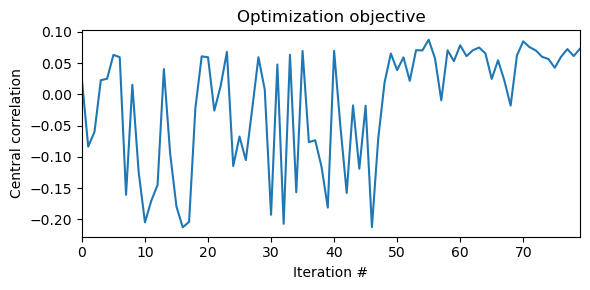

In [ ]:
outputs.plot_optimization_objective();

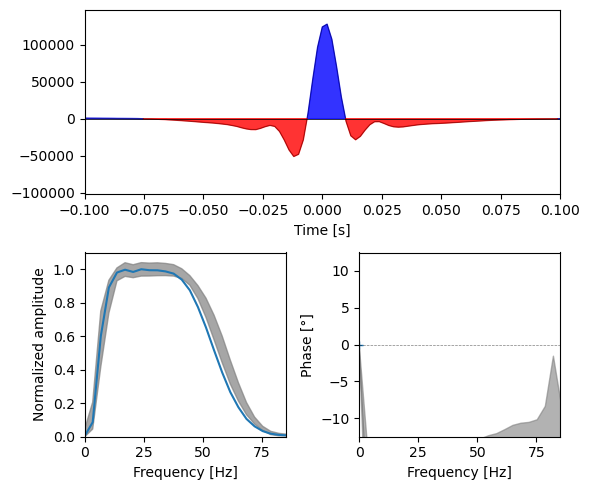

In [ ]:
fig, axes = outputs.plot_wavelet(fmax=85, phi_max=15, figsize=(6, 5))
axes[0].set_xlim((-0.1, 0.1))
axes[2].set_ylim((-12.5, 12.5))
fig.tight_layout()

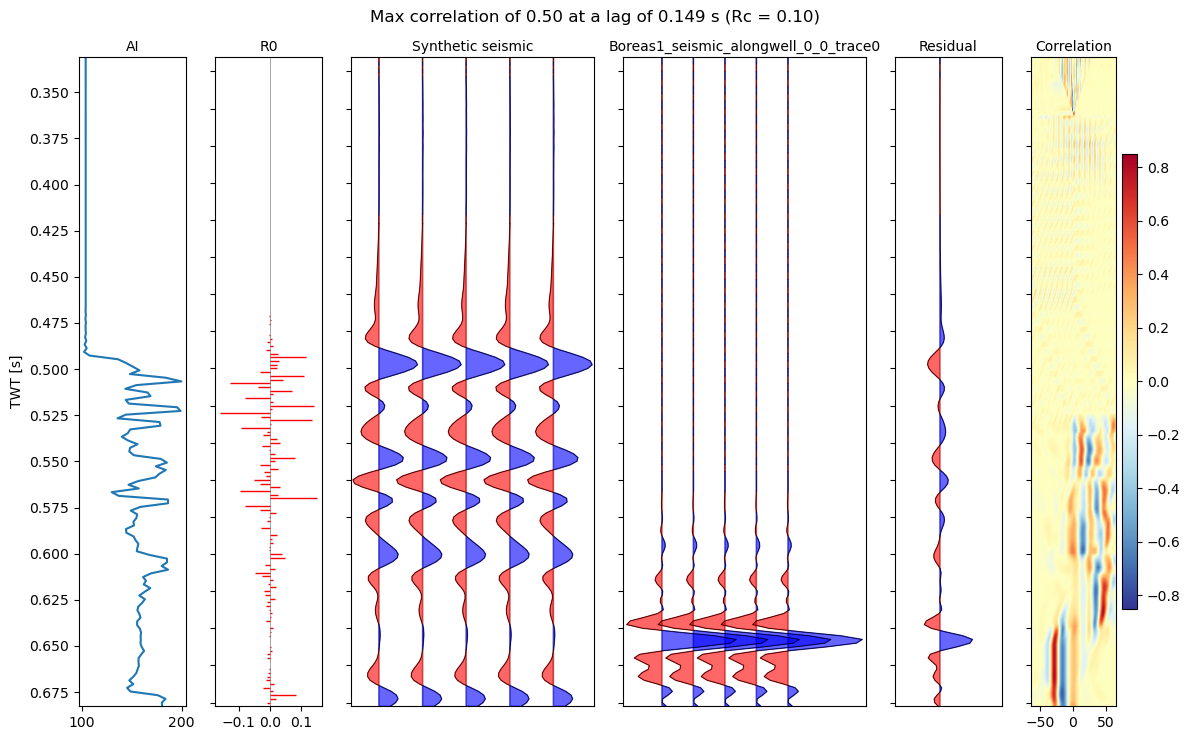

In [ ]:
_scale = 120000
fig, axes = outputs.plot_tie_window(wiggle_scale=_scale, figsize=(12.0, 7.5))

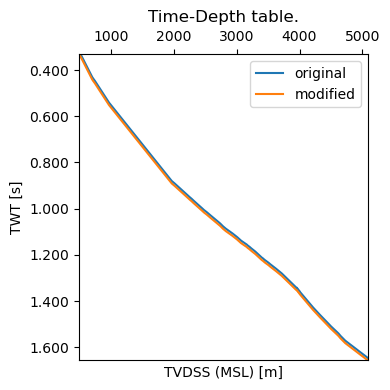

In [ ]:
fig, ax = viz.plot_td_table(inputs.table, plot_params=dict(label="original"))
viz.plot_td_table(outputs.table, plot_params=dict(label="modified"), fig_axes=(fig, ax))
ax.legend(loc="best")

In [ ]:
s_and_s_params = dict(window_length=0.060, max_lag=0.010)  # in seconds

outputs2 = autotie.stretch_and_squeeze(
    inputs,
    outputs,
    wavelet_extractor,
    modeler,
    wavelet_scaling_params,
    best_parameters,
    s_and_s_params,
)

upper
[58.48552445 58.48552778 58.48552269 58.4855285  58.48552368 58.48552546
 58.48552856 58.48551967 58.48553364 58.48551733 58.48553131 58.48552542
 58.48551792 58.48554165 58.48550329 58.48554901 58.48550868 58.48552757
 58.48554529 58.48548223 58.48558729 58.48545937 58.4855754  58.48551598
 58.48547543 58.48564247 58.4853552  58.48571255 58.48537967 58.48556367
 58.48565211 58.48521138 58.4859954  58.48499882 58.4859512  58.48538851
 58.48521022 58.48636809 58.48423241 58.48700708 58.48428919 58.48599243
 58.48630045 58.48327296 58.48907932 58.4813666  58.48910409 58.48399358
 58.48365598 58.49152993 58.47577919 58.49717622 58.47520503 58.49043288
 58.48990668 58.46959787 58.5122174  58.45286206 58.51534937 58.47002459
 58.47539554 58.52833156 58.41170945 58.57677468 58.40215239 58.52885477
 58.51189936 58.37671104 58.66555226 58.26527419 58.72304126 58.25621276
 58.50627822 58.60183393 57.93165938 59.40085067 56.64563181 65.08779
 77.81877011 73.72108461 75.8666903  79.38885646

  0%|          | 0/60 [00:00<?, ?it/s][WARNING 07-07 08:48:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `search_space` to be of type <class 'ax.core.search_space.SearchSpace'>. Got SearchSpace(parameters=[RangeParameter(name='scaler', parameter_type=FLOAT, range=[50000.0, 500000.0])], parameter_constraints=[]) (type: <class 'ax.core.search_space.SearchSpace'>).
[WARNING 07-07 08:48:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `experiment` to be of type typing.Union[ax.core.experiment.Experiment, NoneType]. Got Experiment(wavelet_absolute_scale_estimation) (type: <class 'ax.core.experiment.Experiment'>).
[WARNING 07-07 08:48:01] ax.utils.common.kwargs: `<class 'ax.modelbridge.random.RandomModelBridge'>` expected argument `data` to be of type typing.Union[ax.core.data.Data, NoneType]. Got <ax.core.data.Data object at 0x000001F6878E4A08> (type: <class 'ax.core.data.Data'>).
[WARNING 0

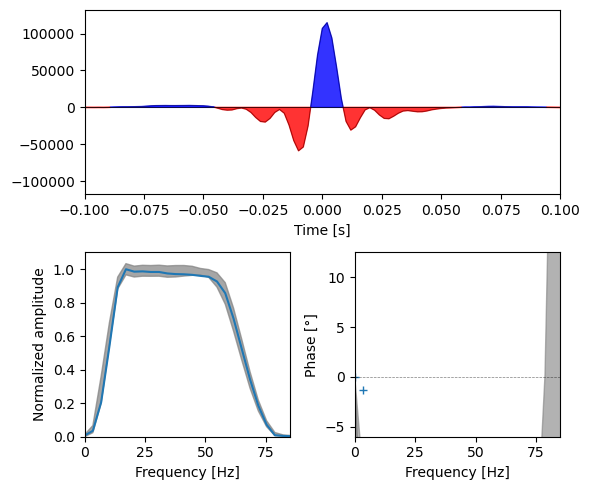

In [ ]:
fig, axes = outputs2.plot_wavelet(fmax=85, phi_max=25, figsize=(6, 5))
axes[0].set_xlim((-0.1, 0.1))
axes[2].set_ylim((-6.0, 12.5))
fig.tight_layout()

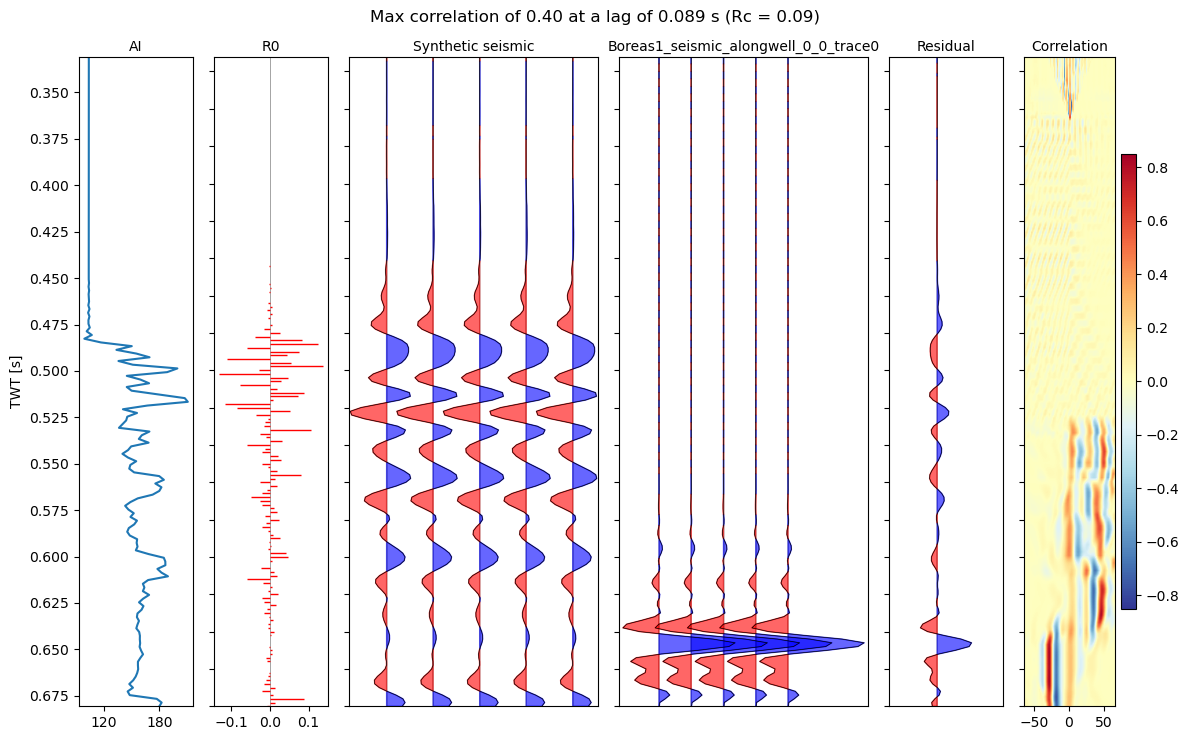

In [ ]:
fig, axes = outputs2.plot_tie_window(wiggle_scale=_scale, figsize=(12.0, 7.5))
from matplotlib.ticker import MaxNLocator

axes[0].xaxis.set_major_locator(MaxNLocator(nbins=2))

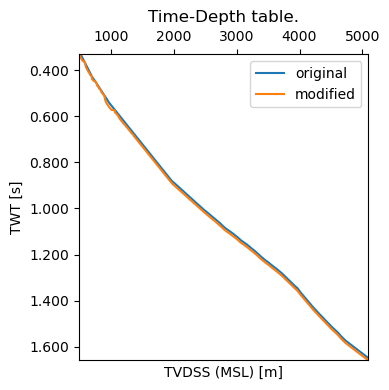

In [ ]:
fig, ax = viz.plot_td_table(inputs.table, plot_params=dict(label="original"))
viz.plot_td_table(
    outputs2.table, plot_params=dict(label="modified"), fig_axes=(fig, ax)
)
ax.legend(loc="best")

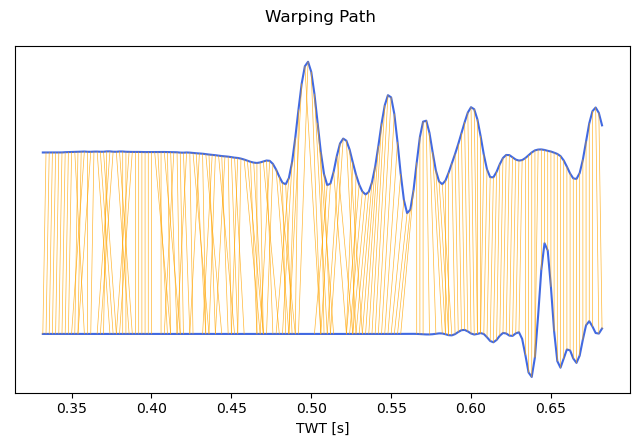

In [ ]:
fig, ax = viz.plot_warping(outputs.synth_seismic, outputs.seismic, outputs2.dlags)